In [1]:
from PIL import Image, ImageEnhance
import PIL.Image
from editor.utils import random, get_colour_lut, apply_pixel_shader
from editor.operations import add_noise, add_random_colour_spill
from pathlib import Path


PIL.Image.MAX_IMAGE_PIXELS = None


DATA = Path('/mnt/wsl/PHYSICALDRIVE1/data/unsplash')
EDIT_COUNT = 5
TARGET_SIZE = 640, 640
originals = sorted(DATA.glob('*.jpg'))
originals_iter = iter(originals)


def random_edit(img: Image) -> Image:
    img = add_noise(img, random(0, 0.1))
    img = ImageEnhance.Contrast(img).enhance(random(0.5, 2))
    img = add_random_colour_spill(img, 1.5)
    img = img.convert("HSV")
    saturation_lut = get_colour_lut(variance=0.2, count=5, type='linear')
    brightness_lut = get_colour_lut(variance=0.2, count=5, type='cubic')
    img = apply_pixel_shader(img, lambda h, s, v: (h, saturation_lut[s], brightness_lut[v]))
    img = img.convert("RGB")
    img = ImageEnhance.Brightness(img).enhance(random(0.5, 2))
    return img


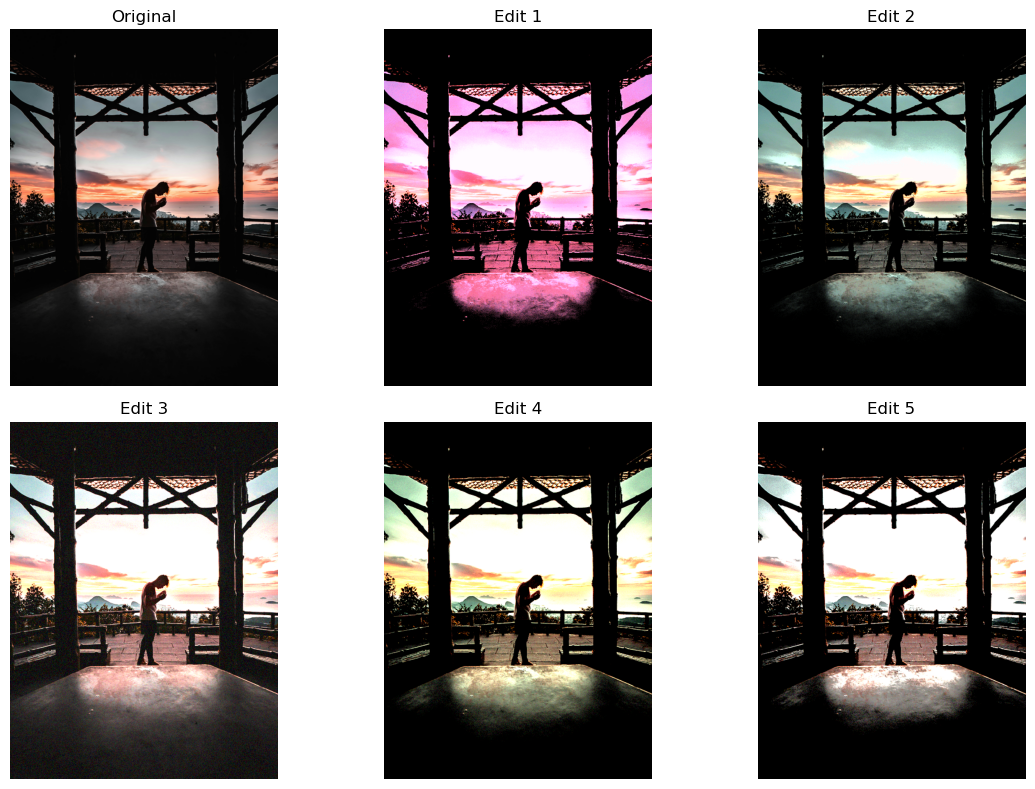

In [2]:
import matplotlib.pyplot as plt

example = next(originals_iter)
img = Image.open(example)
img.thumbnail(TARGET_SIZE, Image.Resampling.LANCZOS)

edits = [
    random_edit(img.copy())
    for i in range(5)
]

images = [img] + edits
titles = ['Original'] + [f'Edit {i}' for i in range(1, len(images))]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

axes = axes.flatten()

for i, (title, image) in enumerate(zip(titles, images)):
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(title)

plt.tight_layout()
plt.show()

In [ ]:
import concurrent.futures
from tqdm import tqdm


def create_random_edits(file: Path):
    try:
        edits_folder = DATA / 'edited' / file.stem
        edits_folder.mkdir(parents=True, exist_ok=True)

        img = Image.open(file)
        img.thumbnail(TARGET_SIZE, Image.Resampling.LANCZOS)
        img.save(edits_folder / 'original.jpg')

        for i in range(EDIT_COUNT):
            clone = img.copy()
            clone = random_edit(clone)
            clone.save(edits_folder / f'{i}.jpg')
    except Exception as e:
        print(e, file)


with tqdm(total=len(originals)) as progress_bar:
    with concurrent.futures.ProcessPoolExecutor(32) as executor:
        futures = [executor.submit(create_random_edits, file) for file in originals]
        for future in concurrent.futures.as_completed(futures):
            future.result()
            progress_bar.update(1)